### Part 2: Training / Testing Splits and Model Performance Analysis

In [1]:
import numpy as np
import pandas as pd
import pathlib
import os
import sklearn
from warnings import simplefilter
# ignore all future warnings / convergence warnings, !!! In a real workflow do not do this !!!
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=sklearn.exceptions.ConvergenceWarning)
from jupyterthemes import jtplot # Ignore this - specific to my dark theme plugin
jtplot.style(theme='onedork')  # Ignore this - specific to my dark theme plugin
jtplot.style(ticks=True, grid=True, figsize=(10, 8)) # Ignore this - specific to my dark theme plugin
# The below is Jupyter "Cell Magic" that allows the matplotlib charts to render in notebook.
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

#### Dataset
We will be using the following as our example dataset:
* https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29
The data is hand extracted features about questionable masses found in breast tissue.
the goal is classify the masses as malignent or benign. See the link for more info.

In [2]:
# Load in the dataset from the data diretory of this repo.
data_fp = pathlib.Path(os.getcwd()).parent / 'data' / 'breast_cancer' / 'wdbc.DATA'
raw_text = open(data_fp, 'r').read()
data_cols = ['radius', 'texture', 'perimeter', 'area',
        'smoothness', 'compactness', 'concavity',
        'concave points', 'symmetry', 'fractal-dimension']
cols = ['ID', 'Label'] + [f"{mod} - {dc}" for dc in data_cols for mod in
                          ['mean', 'se', 'worst']]
data = []
for line in raw_text.split('\n'):
    if line:
        data.append({col: line.split(',')[k] for k, col in enumerate(cols)})
df = pd.DataFrame(data)
print(df.shape)
df.head()

(569, 32)


,ID,Label,mean - radius,se - radius,worst - radius,mean - texture,se - texture,worst - texture,mean - perimeter,se - perimeter,...,worst - concavity,mean - concave points,se - concave points,worst - concave points,mean - symmetry,se - symmetry,worst - symmetry,mean - fractal-dimension,se - fractal-dimension,worst - fractal-dimension
0,842302,M,17.99,10.38,122.8,1001,0.1184,0.2776,0.3001,0.1471,...,25.38,17.33,184.6,2019,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189
1,842517,M,20.57,17.77,132.9,1326,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.8,1956,0.1238,0.1866,0.2416,0.186,0.275,0.08902
2,84300903,M,19.69,21.25,130,1203,0.1096,0.1599,0.1974,0.1279,...,23.57,25.53,152.5,1709,0.1444,0.4245,0.4504,0.243,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,...,14.91,26.5,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.173
4,84358402,M,20.29,14.34,135.1,1297,0.1003,0.1328,0.198,0.1043,...,22.54,16.67,152.2,1575,0.1374,0.205,0.4,0.1625,0.2364,0.07678


In [3]:
# Let's look at the label distribution
pd.DataFrame(df['Label'].value_counts())

,Label
B,357
M,212


Normally we'd also want to do some Exploratory Data Analysis (EDA) and Visualizations to see
if there are any obvious relationships, or useless data. Since this intro is more focused on 
the core mechanics of sklearn I'll skip this for now and assume that since this data is hand
created and fairly low-dimensional that we can assume it is all predictive.

In [4]:
# First we will split our data into training and testing sets
# We will use and 80 / 20 % split for our training / test sets.
from sklearn.model_selection import train_test_split
X = df.values[:, 2: ]
# Sklearn requires integer labels, so we'll convert then using
label_enc = {'M': 1, 'B': 0}
y = df['Label'].apply(lambda l: label_enc[l]).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)
# The train_test_split functtion will automatically randomly partitiion ouor data for us
# The test_size parameter can either be a float in (0, 1), representing the fraction of
# data to hold out for test set, or an integer representing the absolute number of samples.
# It's always a good idea to set a random state / seed so that any results obtained are
# easily repeatable.

In [5]:
# Same classifiers as from Part 1, again we will not change any hyperparameters.
from sklearn.svm import LinearSVC   # Linear Support Vector Machine (SVM) Classifier
from sklearn.linear_model import LogisticRegression  # Logisitc Regression Classifier
from sklearn.naive_bayes import GaussianNB  # Gaussian Naive Bayes
from sklearn.tree import DecisionTreeClassifier # Simple Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier # Random Forest Classifier
from sklearn.neural_network import MLPClassifier # Multilayer Perceptron Algorithm

clf_svc = LinearSVC()
clf_lr = LogisticRegression()
clf_nb = GaussianNB()
clf_dt = DecisionTreeClassifier()
clf_rf = RandomForestClassifier()
clf_mlp = MLPClassifier()

# We will make a dictionary of these classifiers to allow us to loop through them
classifiers = {
    'linear svc': clf_svc,
    'logistic regression': clf_lr,
    'gaussian naive bayes': clf_nb,
    'decision tree': clf_dt,
    'random forest': clf_rf,
    'multilayer perceptron': clf_mlp
}

# Train all the classifiers on the test data set
for clf in classifiers:
    classifiers[clf].fit(X_train, y_train)

Now that our classifiers have been trained on training set, we will look how well they
perform on the independent test set. We will look at a few standard metrics:
* accuracy
* precision
* recall
* confusion matrix

Sklearn accuracy metric functions usually require the input of two arrays of the same shape,
y_true and y_pred, consisting of the true labels and then those predicted by your model.

In [6]:
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.metrics import precision_score, confusion_matrix
# We will write a function that takes a classifier which has already been fit and then computes
# all of the relevent accuracy metrics
def model_performance_overview(clf, X_test, y_test):
    preds = clf.predict(X_test)
    print(f"Accuracy score: {accuracy_score(y_test, preds)}")
    print(f"Precision score: {precision_score(y_test, preds)}")
    print(f"Recall score: {recall_score(y_test, preds)}")
    print(f"f1 score: {f1_score(y_test, preds)}")
    print("Confusion Matrix")
    print(confusion_matrix(y_test, preds))

In [7]:
for clf in classifiers:
    print(clf)
    print('=' * 32)
    model_performance_overview(classifiers[clf], X_test, y_test)
    print('=' * 32)

linear svc
Accuracy score: 0.8771929824561403
Precision score: 1.0
Recall score: 0.7083333333333334
f1 score: 0.8292682926829268
Confusion Matrix
[[66  0]
 [14 34]]
logistic regression
Accuracy score: 0.9736842105263158
Precision score: 0.9787234042553191
Recall score: 0.9583333333333334
f1 score: 0.968421052631579
Confusion Matrix
[[65  1]
 [ 2 46]]
gaussian naive bayes
Accuracy score: 0.9736842105263158
Precision score: 1.0
Recall score: 0.9375
f1 score: 0.967741935483871
Confusion Matrix
[[66  0]
 [ 3 45]]
decision tree
Accuracy score: 0.956140350877193
Precision score: 0.9387755102040817
Recall score: 0.9583333333333334
f1 score: 0.9484536082474228
Confusion Matrix
[[63  3]
 [ 2 46]]
random forest
Accuracy score: 0.9736842105263158
Precision score: 0.9591836734693877
Recall score: 0.9791666666666666
f1 score: 0.9690721649484536
Confusion Matrix
[[64  2]
 [ 1 47]]
multilayer perceptron
Accuracy score: 0.956140350877193
Precision score: 0.9777777777777777
Recall score: 0.916666666666

All of the models perform fairly well, so how can we make resonable comparisons?
Since the training and testing sets were chosen arbitrarily differences in accuracy
could be due to random chance. To analyze this we will use two different types of 
Cross Validation:
* k-Fold Cross Validation
* Monte Carlo Cross Validation

See a discussion about these two here:
https://stats.stackexchange.com/questions/51416/k-fold-vs-monte-carlo-cross-validation

In [8]:
# Here we'll do 5-fold cross validation for just f1 score
from sklearn.model_selection import cross_val_score
cv_res = {}
for clf in classifiers:
    cv_res[clf] = np.array(cross_val_score(classifiers[clf], X, y,
                                              cv=5, scoring='f1'))
metric = 'f1'
for clf in cv_res:
    print(clf)
    print(f"{metric} - average over 5 folds: {cv_res[clf].mean()}")
    print(f"{metric} - standard deviation over 5 folds: {cv_res[clf].std()}")
    print(f"{metric} - minimum over 5 folds: {cv_res[clf].min()}")
    print(f"{metric} - maximum over 5 folds: {cv_res[clf].max()}")
    print('=' * 32)

linear svc
f1 - average over 5 folds: 0.8176613616268789
f1 - standard deviation over 5 folds: 0.09063785609451715
f1 - minimum over 5 folds: 0.6666666666666666
f1 - maximum over 5 folds: 0.923076923076923
logistic regression
f1 - average over 5 folds: 0.9323155745907217
f1 - standard deviation over 5 folds: 0.023574071251342685
f1 - minimum over 5 folds: 0.9
f1 - maximum over 5 folds: 0.963855421686747
gaussian naive bayes
f1 - average over 5 folds: 0.9174975165761105
f1 - standard deviation over 5 folds: 0.022091902125486028
f1 - minimum over 5 folds: 0.8860759493670887
f1 - maximum over 5 folds: 0.9397590361445782
decision tree
f1 - average over 5 folds: 0.8807367681314429
f1 - standard deviation over 5 folds: 0.017983854422559318
f1 - minimum over 5 folds: 0.8604651162790697
f1 - maximum over 5 folds: 0.9135802469135802
random forest
f1 - average over 5 folds: 0.9430400224717989
f1 - standard deviation over 5 folds: 0.03588771924321434
f1 - minimum over 5 folds: 0.896551724137931
f

In [9]:
# We'll now run a 1000 fold Monte Carlo Cross Validation, this can take a little bit of time
# and is only really useful when absolute highest performance is paramount.
from sklearn.model_selection import ShuffleSplit
from tqdm import tqdm_notebook as tqdm
mc_cv_splits = ShuffleSplit(n_splits=1000,
                            test_size=0.2,
                            random_state=2020
                           )
mccv_results = {clf: np.zeros(1000) for clf in classifiers}
for k, split in tqdm(enumerate(mc_cv_splits.split(X)), total=1000): 
    train_ix, test_ix = split[0], split[1]
    for clf in classifiers:
        classifiers[clf].fit(X[train_ix], y[train_ix])
        mccv_results[clf][k] = f1_score(y[test_ix], classifiers[clf].predict(X[test_ix]))

A Jupyter Widget

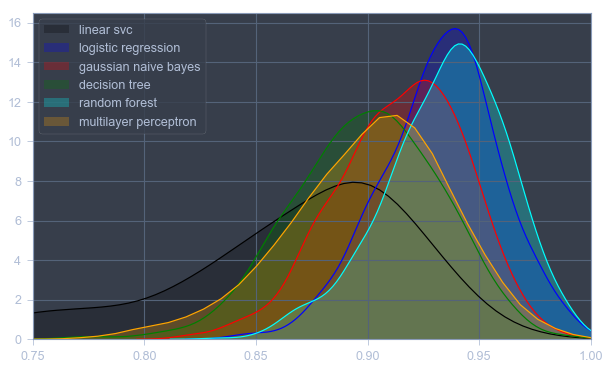

In [10]:
import seaborn as sns
colors = ['black', 'blue', 'red', 'green', 'cyan', 'orange']
plt.figure(figsize=(10,6))
clf_list = list(classifiers)
g = sns.kdeplot(mccv_results[clf_list[0]], shade=True, color=colors[0])
for k, clf in enumerate(clf_list[1:]):
    sns.kdeplot(mccv_results[clf], shade=True, color=colors[k+1])
g.set(xlim=(0.75,1))
g.legend(clf_list, loc=2)